# A U-Net to make t2w images from t1w images

In [1]:
#!pip install tensorflow

In [23]:
import tensorflow as tf
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import PIL
from tensorflow.keras.layers import Activation, BatchNormalization, concatenate, Conv2D, Conv2DTranspose, LeakyReLU

In [24]:
# Constants
BUFFER_SIZE = 400
BATCH_SIZE = 20
IMG_WIDTH = 128
IMG_HEIGHT = 128
EPOCHS = 10 # This is a very small number of epochs... make it as large as you can!

### 1. Prepare data

#### T1W and T2W data

In [25]:
# Image preprocessing
PATH = os.path.join(os.path.abspath('.'), 't1t2/')
OUTPUT_CHANNELS = 3
def load_image(image_file, is_train):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    w = tf.shape(image)[1]
    w = w // 2
    real_image = image[:, :w, :]
    input_image = image[:, w:, :]
    real_image = tf.cast(real_image, tf.float32)
    input_image = tf.cast(input_image, tf.float32)

    # normalizing the images to [0, 1]
    input_image = input_image / 255
    real_image = real_image / 255

    return real_image, input_image

# Create train and test dataset batches
train_dataset = tf.data.Dataset.list_files(PATH + 'train/*.jpg')
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.map(lambda x: load_image(x, True))
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.repeat()

test_dataset = tf.data.Dataset.list_files(PATH + 'test/*.jpg')
test_dataset = test_dataset.map(lambda x: load_image(x, False))
test_dataset = test_dataset.batch(BATCH_SIZE)

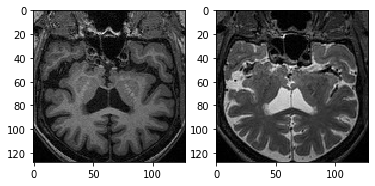

In [26]:
iterator = iter(train_dataset)
el = iterator.get_next()
(a,b) = el
plt.subplot(121); plt.imshow(a[0])
plt.subplot(122); plt.imshow(b[0])

### 2. Build the network

In [27]:
# input
initializer = tf.random_normal_initializer(0., 0.02)
inputs = tf.keras.layers.Input(shape=(IMG_WIDTH,IMG_HEIGHT,OUTPUT_CHANNELS,))

# downsample path
x = Conv2D(32,(3,3),strides=2,padding='same', kernel_initializer=initializer,use_bias=True,name="d1")(inputs)
#x = BatchNormalization()(x)
x1 = LeakyReLU()(x)

x = Conv2D(64,(3,3),strides=2,padding='same', kernel_initializer=initializer,use_bias=True,name="d2")(x1)
x = BatchNormalization()(x)
x2 = LeakyReLU()(x)

x = Conv2D(128,(3,3),strides=2,padding='same', kernel_initializer=initializer,use_bias=True,name="d3")(x2)
x = BatchNormalization()(x)
x3 = LeakyReLU()(x)

x = Conv2D(128,(3,3),strides=2,padding='same', kernel_initializer=initializer,use_bias=True,name="d4")(x3)
x = BatchNormalization()(x)
x4 = LeakyReLU()(x)

# upsample path
x5 = Conv2DTranspose(128,(3,3),strides=2,padding='same', kernel_initializer=initializer,use_bias=True,name="u1")(x4)
x5 = BatchNormalization()(x5)
x5 = Activation('relu')(x5)
x5 = concatenate([x5, x3],axis=-1)

x6 = Conv2DTranspose(64,(3,3),strides=2,padding='same', kernel_initializer=initializer,use_bias=True,name="u2")(x5)
x6 = BatchNormalization()(x6)
x6 = Activation('relu')(x6)
x6 = concatenate([x6, x2],axis=-1)

x7 = Conv2DTranspose(32,(3,3),strides=2,padding='same', kernel_initializer=initializer,use_bias=True,name="u3")(x6)
x7 = BatchNormalization()(x7)
x7 = Activation('relu')(x7)
x7 = concatenate([x7, x1],axis=-1)

# output
x8 = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS,(3, 3),strides=2,padding='same', kernel_initializer=initializer,name="u8")(x7)
x8 = tf.keras.layers.Activation('sigmoid')(x8)

unet = tf.keras.Model(inputs, x8)
unet_optimizer = tf.optimizers.Adam(learning_rate=0.001)
unet.compile(optimizer=unet_optimizer, loss='mean_squared_error')

In [28]:
unet.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
d1 (Conv2D)                     (None, 64, 64, 32)   896         input_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_4 (LeakyReLU)       (None, 64, 64, 32)   0           d1[0][0]                         
__________________________________________________________________________________________________
d2 (Conv2D)                     (None, 32, 32, 64)   18496       leaky_re_lu_4[0][0]              
____________________________________________________________________________________________

### 3. Train

In [29]:
# fit
unet.fit(train_dataset, steps_per_epoch=400, epochs=EPOCHS)

Train for 400 steps
Epoch 1/10
400/400 [==============================] - 62s 155ms/step - loss: 0.0227
Epoch 2/10
400/400 [==============================] - 63s 157ms/step - loss: 0.0155
Epoch 3/10
400/400 [==============================] - 67s 168ms/step - loss: 0.0140
Epoch 4/10
400/400 [==============================] - 66s 165ms/step - loss: 0.0128
Epoch 5/10
400/400 [==============================] - 67s 168ms/step - loss: 0.0124
Epoch 6/10
400/400 [==============================] - 69s 173ms/step - loss: 0.0120
Epoch 7/10
400/400 [==============================] - 66s 165ms/step - loss: 0.0119
Epoch 8/10
400/400 [==============================] - 66s 166ms/step - loss: 0.0116
Epoch 9/10
400/400 [==============================] - 65s 162ms/step - loss: 0.0113
Epoch 10/10
400/400 [==============================] - 67s 167ms/step - loss: 0.0114


### 4. Predict

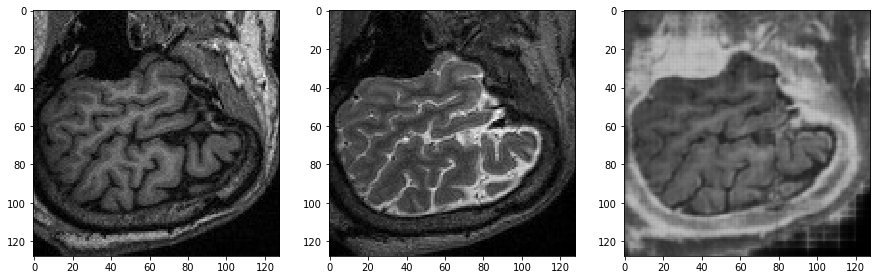

In [30]:
iterator = iter(test_dataset)
el = iterator.get_next()
(a,b) = el
output = unet.predict(b, steps=1)
plt.figure(figsize=(15,15))
plt.subplot(131); plt.imshow(a[0])
plt.subplot(132); plt.imshow(b[0])
plt.subplot(133); plt.imshow(output[0])

## 5. Save

In [52]:
checkpoint_path = "./t1t2/cp-{epoch:04d}.ckpt"
unet.save_weights(checkpoint_path.format(epoch=500))

In [53]:
!open .